In [28]:
using Pkg

Pkg.add("Graphs")
Pkg.add("JuMP")
Pkg.add("GLPK")
Pkg.add("BenchmarkTools")
Pkg.add("Distances")
Pkg.add("Plots")
ENV["GUROBI_HOME"] = "/Library/gurobi952/macos_universal2/"
Pkg.add("Gurobi")
Pkg.build("Gurobi")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Ch

In [1]:
struct Delivery
    x::Float64
    y::Float64
end

function random_delivery()
    x = rand(0.0:0.1:100.0)
    y = rand(0.0:0.1:100.0)
    return Delivery(x, y)
end

struct TSProblem
    deliveries::Array{Delivery}
end

function random_instance(n_deliveries)
    deliveries = [random_delivery() for _=1:n_deliveries]
    problem = TSProblem(deliveries)
    return problem
end

function dist(del1::Delivery, del2::Delivery)
    return sqrt((del1.x - del2.x)^2 + (del1.y - del2.y)^2)
end

function calc_travelmatrix(deliveries::Array{Delivery})
    tm = zeros(Float64, length(deliveries), length(deliveries))
    for i = 1:length(deliveries)
        for j = 1:length(deliveries)
            tm[i, j] = dist(deliveries[i], deliveries[j])
        end
    end
    return tm
end


calc_travelmatrix (generic function with 1 method)

In [2]:
using Graphs
using Test


test_m = [0 1 0 0; 
          1 0 0 0;
          0 0 0 1;
          0 0 1 0;]
"""
given an incidence matrix of a tsp route return nodes of the shortest cycle
"""
function shortest_subtour(matrix::Matrix{Int64})
    g = Graphs.SimpleDiGraph(matrix)
    cycles = []
    max_cycle_len = Graphs.nv(g)
    for node in Graphs.vertices(g)
        push!(cycles, Graphs.neighborhood(g, node, max_cycle_len))
    end
    cycles = filter(x -> max_cycle_len > length(x) > 1, cycles)
    if isempty(cycles)
        return []
    end
    return sort(cycles, by=length)[1]
end
@test shortest_subtour(test_m) == [1, 2]

Test Passed
  Expression: shortest_subtour(test_m) == [1, 2]
   Evaluated: [1, 2] == [1, 2]

In [3]:
test_m_empty = [0 0 0 0; 
          0 0 0 0;
          0 0 0 0;
          0 0 0 0;]
@test shortest_subtour(test_m_empty) == []

Test Passed
  Expression: shortest_subtour(test_m_empty) == []
   Evaluated: Any[] == Any[]

In [4]:
test_m_no_subtours = 
         [0 1 0 0; 
          0 0 1 0;
          0 0 0 1;
          1 0 0 0;]
@test shortest_subtour(test_m_empty) == []

Test Passed
  Expression: shortest_subtour(test_m_empty) == []
   Evaluated: Any[] == Any[]

In [5]:
test_subtours = 
    [0 0 1 0 0 0;
     0 0 0 0 1 0;
     0 0 0 0 0 1;
     0 1 0 0 0 0;
     0 0 0 1 0 0;
     1 0 0 0 0 0]
@test shortest_subtour(test_subtours) == [1, 3, 6]

Test Passed
  Expression: shortest_subtour(test_subtours) == [1, 3, 6]
   Evaluated: [1, 3, 6] == [1, 3, 6]

In [6]:
test_subtours2 = 
   [0 0 1 0 0; 
    1 0 0 0 0;
    0 0 0 0 1;
    0 1 0 0 0;
    0 0 0 1 0]
@test shortest_subtour(test_subtours2) == []

Test Passed
  Expression: shortest_subtour(test_subtours2) == []
   Evaluated: Any[] == Any[]

 65.634554 seconds (222.86 M allocations: 6.524 GiB, 1.46% gc time, 0.39% compilation time)


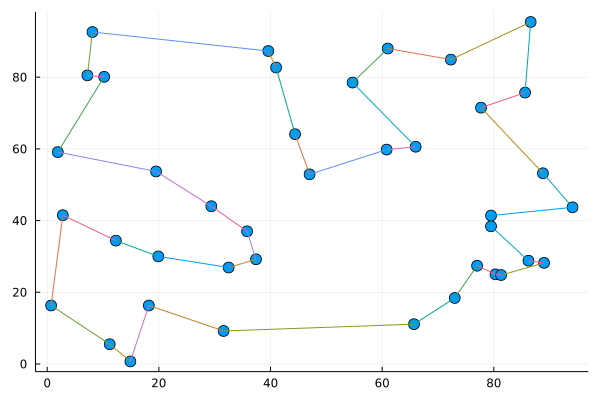

In [20]:
using JuMP
import GLPK
import Gurobi
using BenchmarkTools
using Plots

function display_solution(problem, route)
    x_pos = [c.x for c in problem.deliveries]
    y_pos = [c.y for c in problem.deliveries]
    plot_result = scatter(x_pos, y_pos, shape = :circle, markersize = 6)
    for i in 1:length(problem.deliveries)
        for j in 1:length(problem.deliveries)
            val = route[i, j]
            if val > 0
                del1 = problem.deliveries[i]
                del2 = problem.deliveries[j]
                plot!([del1.x, del2.x], [del1.y, del2.y], legend = false)
            end
        end
    end
    return plot_result
end;

function solve_tsp(deliveries::Int64, solver, show_viz=false)
    problem=random_instance(deliveries)
    travelmatrix = calc_travelmatrix(problem.deliveries)
    model = Model(solver)
    set_silent(model)
    # route is an adjence matrix representing a route traveled
    route=@variable(model, route[1:length(problem.deliveries), 1:length(problem.deliveries)], Bin)

    # ensure all events are planned
    @constraint(model, [i = 1:length(problem.deliveries)], sum(route[i, :]) == 1.0)
    @constraint(model, [c = 1:length(problem.deliveries)], sum(route[:, c]) == 1.0)
    # disallow traveling to itself
    @constraint(model, [j = 1:length(problem.deliveries)], route[j, j] == 0)

    traveltime = travelmatrix.* route 
    @objective(model, Min, sum(traveltime))
    function subtour_indices(routes)
        
        if length(cycle) <= 1
            return []
        end
        return 
    end

    function callback(cb_data)
        status = callback_node_status(cb_data, model)
        if status == MOI.CALLBACK_NODE_STATUS_FRACTIONAL
            return
        end
        x_val = callback_value.(cb_data, route)
        x_val = round.(x_val)
        x_val = Int64.(x_val)
        cycle = shortest_subtour(x_val)
        sub_inds = [(i, j) for (i, j) in Iterators.product(cycle, cycle) if i != j]
        if length(sub_inds) > 0
            con = @build_constraint(sum(route[i, j] for (i,j) in sub_inds) <= length(cycle) -1 )
            MOI.submit(model, MOI.LazyConstraint(cb_data), con)
        end
    end
    MOI.set(model, MOI.LazyConstraintCallback(), callback)
    optimize!(model)
    route_val = JuMP.value.(route)
    if show_viz
        return display_solution(problem, route_val)
    end
end

@time solve_tsp(40, GLPK.Optimizer, true)


  8.324897 seconds (10.81 M allocations: 338.591 MiB, 0.48% gc time)


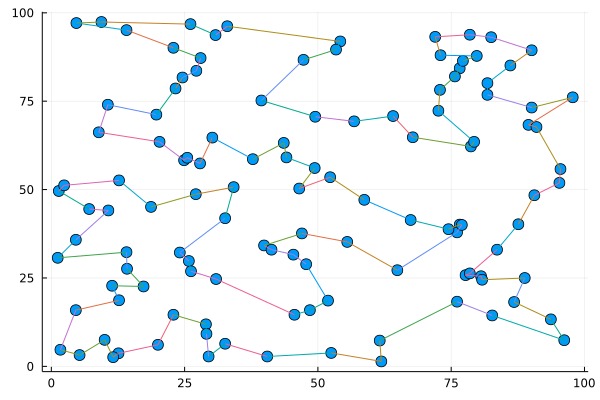

In [27]:
@time solve_tsp(120, Gurobi.Optimizer, true)

In [30]:
@benchmark solve_tsp(30, GLPK.Optimizer) evals=3 samples=20 seconds=3600

BenchmarkTools.Trial: 20 samples with 3 evaluations.
 Range (min … max):  322.160 ms …    2.937 s  ┊ GC (min … max): 1.85% … 1.53%
 Time  (median):        1.137 s               ┊ GC (median):    1.46%
 Time  (mean ± σ):      1.329 s ± 732.204 ms  ┊ GC (mean ± σ):  1.57% ± 0.21%

  ▁   ▁ ▁▁ █▁  ▁ ▁ ▁  ▁     ▁▁  ▁   ▁ ▁▁     ▁          ▁     ▁  
  █▁▁▁█▁██▁██▁▁█▁█▁█▁▁█▁▁▁▁▁██▁▁█▁▁▁█▁██▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁█ ▁
  322 ms           Histogram: frequency by time          2.94 s <

 Memory estimate: 48.24 MiB, allocs estimate: 1437764.

In [28]:
@benchmark solve_tsp(50, Gurobi.Optimizer) evals=3 samples=20 seconds=3600

BenchmarkTools.Trial: 20 samples with 3 evaluations.
 Range (min … max):  202.919 ms … 434.634 ms  ┊ GC (min … max): 0.81% … 0.42%
 Time  (median):     263.584 ms               ┊ GC (median):    0.68%
 Time  (mean ± σ):   270.858 ms ±  51.169 ms  ┊ GC (mean ± σ):  0.63% ± 0.18%

             █                                                   
  ▇▁▁▇▁▇▁▇▁▇▇█▁▁▁▇▇▇▁▇▇▇▇▁▁▁▁▇▁▁▇▁▁▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▇ ▁
  203 ms           Histogram: frequency by time          435 ms <

 Memory estimate: 18.95 MiB, allocs estimate: 470803.

In [29]:
@benchmark solve_tsp(80, Gurobi.Optimizer) evals=3 samples=20 seconds=3600

BenchmarkTools.Trial: 20 samples with 3 evaluations.
 Range (min … max):  972.531 ms …    2.254 s  ┊ GC (min … max): 0.71% … 0.38%
 Time  (median):        1.192 s               ┊ GC (median):    0.56%
 Time  (mean ± σ):      1.270 s ± 307.507 ms  ┊ GC (mean ± σ):  0.51% ± 0.10%

  █▁ █▁▁ ▁ ▁█ █▁     ▁▁  ▁  ▁          ▁                      ▁  
  ██▁███▁█▁██▁██▁▁▁▁▁██▁▁█▁▁█▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  973 ms           Histogram: frequency by time          2.25 s <

 Memory estimate: 73.46 MiB, allocs estimate: 2119963.